**Introduction:**

This notebook is intended as a self-tutorial on using Principle Component Analysis (PCA) in a real-world application. This notebook uses the famous olliveti dataset and PCA to perform:
- Face Recognition
- Face reconstruction from half-images

PCA is a mechanism of performing dimensionality reduction.  Learning is performed on a dataset with reduced features improving the processing speed and reducing feature redundancy.

In [98]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import skimage.io as skio

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("olivetti_faces.npy"))

# Any results you write to the current directory are saved as output.

['olivetti_faces.npy', 'olivetti_faces_target.npy']


**Preparing training and test set**

The dataset is divided into training and test set. The original dataset has 10 images of 40 people = 400 images.. The function below prepares  test set by keeping one image per person in the test set  = 40 and the remaining images (360) are retained in the training set.

In [99]:

def load_train_test_set():
    faces  = np.load('olivetti_faces.npy/olivetti_faces.npy')
    target = np.load('olivetti_faces.npy/olivetti_faces_target.npy')
    print("Original faces.shape:"+ str(faces.shape))
    print("Original target.shape:"+ str(target.shape))
    
    # create a test set that takes one face for each person
    test_index = list(range(9,400,10))
    faces_test = faces[test_index]
    target_test = target[test_index]
    
    # preprare training set by removing items in test set
    faces_train = faces.copy()
    target_train =  target.copy()
    for i in test_index[::-1]:
        faces_train  = np.delete(faces_train,i,axis =0 )
        target_train = np.delete(target_train,i,axis =0 )
    
    print("faces_train.shape:" +str(faces_train.shape)) 
    print("target_train.shape:" +str(target_train.shape))
    print("faces_test.shape:" +str(faces_test.shape)) 
    print("target_test.shape:" +str(target_test.shape))
    return faces_train, target_train, faces_test, target_test


In [100]:
faces_train, target_train, faces_test, target_test = load_train_test_set()

Original faces.shape:(400, 64, 64)
Original target.shape:(400,)
faces_train.shape:(360, 64, 64)
target_train.shape:(360,)
faces_test.shape:(40, 64, 64)
target_test.shape:(40,)


**Visualize a few training images**

In [101]:
def show_sample_training_and_test_images(faces_train, faces_test):
    fig = plt.figure()
    fig.add_subplot(1, 4, 1)
    plt.imshow(faces_train[0], cmap='gray')
    fig.add_subplot(1, 4, 2)
    plt.imshow(faces_train[1], cmap='gray')
    fig.add_subplot(1, 4, 3)
    plt.imshow(faces_train[9], cmap='gray')
    fig.add_subplot(1, 4, 4)
    plt.imshow(faces_train[10], cmap='gray')
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(faces_test[0], cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(faces_test[1], cmap='gray')

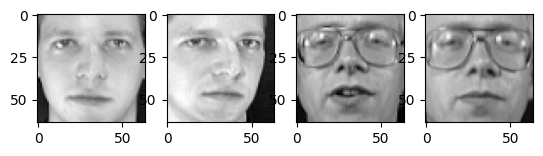

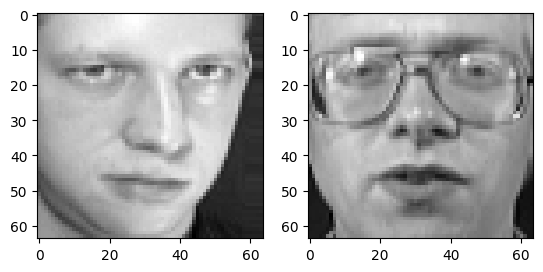

In [102]:
show_sample_training_and_test_images(faces_train, faces_test)

**Pre-process data**

Data preprocessing involves centering the images by subtracting each feature by its mean across training samples and  then dividing it by its standard deviation. This serves two purposes:
1.  The data is normalized. This avoids multiplication of arbitarily large values
2.  It makes all features unit-less. This ensures that one feature does not have value ranges different from another just due to difference in the units ( e.g. one being in cm and another meters ) 

In [103]:
def preprocess_data( faces_train, faces_test ):
    # flatten the imagaes from 
    X_train =  np.reshape(faces_train,(faces_train.shape[0], -1 ))
    X_test =   np.reshape(faces_test, (faces_test.shape[0], -1 ))
    mu = np.mean(X_train, axis = 0 )
    std_dev = np.mean(X_train, axis = 0)
    std_dev_mod = np.copy(std_dev)
    std_dev_mod[std_dev == 0 ] = 1
    X_train = (X_train - mu)/std_dev_mod
    # normalize the test set with same mu and std values as training set 
    X_test = (X_test - mu)/std_dev_mod
    return X_train, X_test   
    

In [104]:
X_train, X_test = preprocess_data(faces_train, faces_test )
print("X_train.shape=" + str(X_train.shape))
print("X_test.shape="  + str(X_test.shape)) 
# print(target_train,target_test)


X_train.shape=(360, 4096)
X_test.shape=(40, 4096)


In [105]:
# import copy, math

# def sigmoid(z):
#     """
#     Compute the sigmoid of z
#     Args:
#         z (ndarray): A scalar, numpy array of any size.
#     Returns:
#         g (ndarray): sigmoid(z), with the same shape as z
#     """
#     g = 1/(1+np.exp(-z))
#     return g



In [106]:
# def compute_cost_logistic_reg(X, y, w, b, lambda_ = 1):
#     """
#     Computes the cost over all examples
#     Args:
#     Args:
#       X (ndarray (m,n): Data, m examples with n features
#       y (ndarray (m,)): target values
#       w (ndarray (n,)): model parameters  
#       b (scalar)      : model parameter
#       lambda_ (scalar): Controls amount of regularization
#     Returns:
#       total_cost (scalar):  cost 
#     """

#     m,n  = X.shape
#     cost = 0.
#     for i in range(m):
#         z_i = np.dot(X[i], w) + b                                      #(n,)(n,)=scalar, see np.dot
#         f_wb_i = sigmoid(z_i)                                          #scalar
#         cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)      #scalar
#     cost = cost/m                                                      #scalar

#     reg_cost = 0
#     for j in range(n):
#         reg_cost += (w[j]**2)                                          #scalar
#     reg_cost = (lambda_/(2*m)) * reg_cost                              #scalar
    
#     total_cost = cost + reg_cost                                       #scalar
#     return total_cost 

In [107]:
# def compute_gradient_logistic(X, y, w, b, lambda_): 
#     """
#     Computes the gradient for linear regression 
#     Args:
#       X (ndarray (m,n): Data, m examples with n features
#       y (ndarray (m,)): target values
#       w (ndarray (n,)): model parameters  
#       b (scalar)      : model parameter
#     Returns
#       dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
#       dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b. 
#     """
#     m,n = X.shape
#     dj_dw = np.zeros((n,))                           #(n,)
#     dj_db = 0.

#     for i in range(m):
#         f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
#         err_i  = f_wb_i  - y[i]                       #scalar
#         for j in range(n):
#             dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
#         dj_db = dj_db + err_i
#     dj_dw = dj_dw/m                                   #(n,)
#     dj_db = dj_db/m                                   #scalar
    
#     for j in range(n):
#         dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]

#     return dj_db, dj_dw 

In [108]:
# def gradient_descent(X, y, w_in, b_in, alpha, num_iters, lambda_): 
#     """
#     Performs batch gradient descent
    
#     Args:
#       X (ndarray (m,n)   : Data, m examples with n features
#       y (ndarray (m,))   : target values
#       w_in (ndarray (n,)): Initial values of model parameters  
#       b_in (scalar)      : Initial values of model parameter
#       alpha (float)      : Learning rate
#       num_iters (scalar) : number of iterations to run gradient descent
      
#     Returns:
#       w (ndarray (n,))   : Updated values of parameters
#       b (scalar)         : Updated value of parameter 
#     """
#     w = copy.deepcopy(w_in)  #avoid modifying global w within function
#     b = b_in
    
#     for i in range(num_iters):
#         # Calculate the gradient and update the parameters
#         dj_db, dj_dw = compute_gradient_logistic(X, y, w, b, lambda_)   

#         # Update Parameters using w, b, alpha and gradient
#         w = w - alpha * dj_dw               
#         b = b - alpha * dj_db               


        
#     return w, b         #return final w,b and J history for graphing


In [109]:
import copy
import numpy as np

def sigmoid(z):
    """
    Compute the sigmoid of z
    Args:
        z (ndarray): A scalar, numpy array of any size.
    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
    """
    # Apply numerical stability techniques
    z = np.clip(z, -500, 500)  # Clip values to avoid overflow/underflow
    g = np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
    return g

def compute_cost_logistic(X, y, w, b):
    m = X.shape[0]
    z = np.dot(X, w) + b
    f_wb = sigmoid(z)

    # Apply numerical stability techniques
    f_wb = np.clip(f_wb, 1e-15, 1 - 1e-15)  # Clip values to avoid division by zero

    cost = -np.mean(y * np.log(f_wb) + (1 - y) * np.log(1 - f_wb))
    return cost

def compute_gradient_logistic(X, y, w, b, lambda_):
    m = X.shape[0]
    z = np.dot(X, w) + b
    f_wb = sigmoid(z)
    err = f_wb - y
    dj_dw = np.dot(X.T, err) / m + (lambda_ / m) * w
    dj_db = np.mean(err)
    return dj_dw, dj_db

def gradient_descent(X, y, w_in, b_in, alpha, num_iters,lambda_):
    J_history = []
    w = copy.deepcopy(w_in)
    b = b_in

    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient_logistic(X, y, w, b, lambda_)

        w -= alpha * dj_dw
        b -= alpha * dj_db

        if i < 100000:
            J_history.append(compute_cost_logistic(X, y, w, b))

        if i % (num_iters // 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}")

    return w, b, J_history

def one_vs_all(y, class_label):
    """
    Transforms the multi-class target variable into a binary variable.
    Assigns 1 to instances of the specified class label, and 0 to the rest.

    Args:
        y (ndarray (m,)): Target variable with m examples.
        class_label (scalar): Class label to assign as 1.

    Returns:
        y_binary (ndarray (m,)): Binary target variable.
    """
    y_binary = np.where(y == class_label, 1, 0)
    return y_binary

def train_one_vs_all(X, y, w_in, b_in, alpha, num_iters,lambda_):
    """
    Trains multiple binary logistic regression models using the one-vs-all approach.

    Args:
        X (ndarray (m,n)): Training data with m examples and n features.
        y (ndarray (m,)): Target variable with multi-class labels.
        w_in (ndarray (n,)): Initial values of model parameters.
        b_in (scalar): Initial value of the intercept term.
        alpha (float): Learning rate.
        num_iters (scalar): Number of iterations to run gradient descent.

    Returns:
        models (dict): Dictionary containing the trained models for each class.
    """
    classes = np.unique(y)
    models = {}

    for class_label in classes:
        y_binary = one_vs_all(y, class_label)
        w, b, _ = gradient_descent(X, y_binary, w_in, b_in, alpha, num_iters,lambda_)
        models[class_label] = (w, b)

    return models

def predict_multi_class(X, models):
    """
    Predicts the labels for an incoming testing set in a multi-class problem.

    Args:
        X (ndarray (m,n)): Testing data with m examples and n features.
        models (dict): Dictionary containing the trained models for each class.

    Returns:
        y_pred (ndarray (m,)): Predicted labels for the testing set.
    """
    y_pred = []
    for i in range(X.shape[0]):
        class_scores = {}
        for class_label, (w, b) in models.items():
            z = np.dot(X[i], w) + b
            class_scores[class_label] = sigmoid(z)
        predicted_class = max(class_scores, key=class_scores.get)
        y_pred.append(predicted_class)
    return np.array(y_pred)


In [110]:
# def predict(X, w, b):
#     """
#     Predicts the labels for an incoming testing set.

#     Args:
#         X (ndarray (m,n)): Testing data with m examples and n features.
#         w (ndarray (n,)): Model parameters.
#         b (scalar): Model parameter.

#     Returns:
#         y_pred (ndarray (m,)): Predicted labels for the testing set.
#     """
#     z = np.dot(X, w) + b
#     y_pred = np.round(sigmoid(z)).astype(int)
#     return y_pred


def calculate_accuracy(y_true, y_pred):
    """
    Calculates the accuracy of the model.

    Args:
        y_true (ndarray (m,)): True labels.
        y_pred (ndarray (m,)): Predicted labels.

    Returns:
        accuracy (float): Accuracy of the model in percentage.
    """
    correct = np.sum(y_true == y_pred)
    total = y_true.shape[0]
    accuracy = (correct / total) * 100
    return accuracy


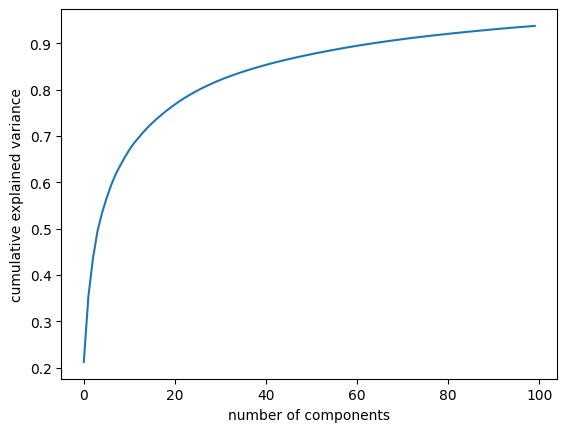

Projecting the input data on the eigenfaces orthonormal basis
Iteration    0: Cost nan


C:\Users\micha\AppData\Local\Temp\ipykernel_56464\57673248.py:23: RuntimeWarning: overflow encountered in exp
  g = np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
C:\Users\micha\AppData\Local\Temp\ipykernel_56464\57673248.py:23: RuntimeWarning: invalid value encountered in divide
  g = np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
C:\Users\micha\AppData\Local\Temp\ipykernel_56464\57673248.py:34: RuntimeWarning: divide by zero encountered in log
  cost = -np.mean(y * np.log(f_wb) + (1 - y) * np.log(1 - f_wb))
C:\Users\micha\AppData\Local\Temp\ipykernel_56464\57673248.py:34: RuntimeWarning: invalid value encountered in multiply
  cost = -np.mean(y * np.log(f_wb) + (1 - y) * np.log(1 - f_wb))


Iteration  100: Cost nan
Iteration  200: Cost nan
Iteration  300: Cost nan
Iteration  400: Cost 0.10043271969950113
Iteration  500: Cost 0.022651167211495547
Iteration  600: Cost 0.008495987715885849
Iteration  700: Cost 0.005147373335894064
Iteration  800: Cost 0.003706292892604937
Iteration  900: Cost 0.0029047507197887514
Iteration    0: Cost nan
Iteration  100: Cost nan
Iteration  200: Cost nan
Iteration  300: Cost nan
Iteration  400: Cost nan
Iteration  500: Cost nan
Iteration  600: Cost nan
Iteration  700: Cost nan
Iteration  800: Cost nan
Iteration  900: Cost nan
Iteration    0: Cost nan
Iteration  100: Cost nan
Iteration  200: Cost nan
Iteration  300: Cost nan
Iteration  400: Cost nan
Iteration  500: Cost nan
Iteration  600: Cost 0.00981705845591551
Iteration  700: Cost 0.00613085354456321
Iteration  800: Cost 0.004435946444295169
Iteration  900: Cost 0.0034592393605015798
Iteration    0: Cost nan
Iteration  100: Cost nan
Iteration  200: Cost nan
Iteration  300: Cost inf
Iterat

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV





# show_orignal_images(pixels)
## Step 2: Split Dataset into training and testing
x_train = X_train 
x_test = X_test 
y_train = target_train
y_test = target_test

## Step 3: Perform PCA.
pca = PCA(n_components=100)
pca = pca.fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

# show_eigenfaces(pca)

## Step 4: Project Training data to PCA
print("Projecting the input data on the eigenfaces orthonormal basis")
Xtrain_pca = pca.transform(x_train)

##############

#Logistic
w_tmp  = np.zeros_like(X_train[0]) + 1
b_tmp  = 0.
alph = 0.1
iters = 1000
lambda_tmp = 0.7
models = train_one_vs_all(X_train, y_train, w_tmp, b_tmp, alph, iters,lambda_tmp) 
# print(f"\nupdated parameters: w:{w_out}, b:{b_out}")

y_pred = predict_multi_class(x_test,models)
print(calculate_accuracy(y_test,y_pred))
#endof Logistic




## Step 5: Initialize Classifer and fit training data
# clf = SVC(kernel='rbf',C=1000,gamma=0.001)
# clf = clf.fit(Xtrain_pca, y_train)


## Step 6: Perform testing and get classification report
# print("Predicting people's names on the test set")
# t0 = time()
# Xtest_pca = pca.transform(x_test)
# y_pred = clf.predict(Xtest_pca)
# print("done in %0.3fs" % (time() - t0))
# # print(classification_report(y_test, y_pred))

# param_grid = {'kernel' : ('poly', 'rbf'), 'C':[0.01, 0.1, 0.5, 1, 10,50,100,1000],'gamma':[0.1,0.01,0.001,0.0001,0.00001,0.000001]}
# gs = GridSearchCV(estimator=SVC(kernel='rbf'),
# param_grid=param_grid,
# refit=True, # choose best model and refit to entire data
# n_jobs=None)
# gs.fit(Xtrain_pca,y_train)

# best_params = gs.best_params_
# print('Best Params:', best_params)
# bestModel = SVC(kernel=best_params['kernel'],C=best_params['C'])
# bestModel.fit(Xtrain_pca,y_train)
# print('Accuracy of SVC on training set: {:.2f}'.format(bestModel.score(Xtrain_pca,y_train)*100))
# print('Accuracy of SVC on test set: {:.2f}'.format(bestModel.score(Xtest_pca,y_test)*100))


# print(accuracy_score(y_test,y_pred))



**Principle Component Analysis**

As defined in Wikipedia " Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. It can be derived that these principal components are nothing but  eigenvectors sorted by their eigenvalues. Eigenvectors corresponding to the highest eigenvalues  provide the most information about an image.  We can reduce dimentionality of an image by selecting eigenvectors sufficient enough to extract most of the important features and peforming orthogonal projection of the image vector on this eigenbasis. The procedure is as follows:

X = Training set of shape ( N x D ) where N = number of images , D number of pixels per image

1. Calculate covaraince matrix for training set X with images centered around the mean:

    S = $X^T X$
    
    S is a D x D matrix
2. Find the eigenvectors for X and sort  them in descending order by their eigenvalues
3. Select  K eigenvectors corresponding to the K  largest eigenvalues.



We shall briefly discuss  how to find the value of K.  However, before that we must discuss how to handle situations where the number of features >> number of samples i.e. D >> N. In such a scenario a 
D x D matrix shall be huge to process. To optimize this processing we calculate covariance matrix C as follows:

1. C = $X X^T$
This produces  S which is an N x N matrix which is much smaller to process.
2. We extract the eignvectors and eigenvalues of C ( **w**,** v** )and select K vectors coressponding to K largest eignevalues 
3. To get eigenvectors corresponding to S , we know  that :

    $X^T X$ w^i = v^i w^i
    
    If we left multiply by $X^T$,
    
    $X^T  X X^T w^i = X^T v^i w^i$
    
    since $v^i$ is a scalar:
    
    $X^T  X (X^T w^i) = v^i (X^T  w^i)$
    
    We see that $X^T w $ is the eigenvector of $S = ( X^T X )$

In [112]:
class PCA:
    def __init__( self, optimize = False ):
        self.__optimize = optimize
        
    def __calculate_covariance_matrix( self, X ):
        if self.__optimize:
            return X @ X.T
        else:
            return X.T @ X

    def __get_eigenvecs_sorted_by_eigenvals( self, S ):
        w, v = np.linalg.eig(S)
        sorted_index = np.argsort(w)[::-1]
        eigenvals = w[sorted_index]
        eigenvecs = v[:,sorted_index]
        return eigenvals, eigenvecs

    def __get_eigenvec_for_original_matrix(  self, X, eigenvecs ):
        U = X.T @ eigenvecs
        return U
    
    def fit( self, X ):
        S = self.__calculate_covariance_matrix( X )
        eigenvals,eigenvecs =   self.__get_eigenvecs_sorted_by_eigenvals( S )
        if self.__optimize :
            B = self.__get_eigenvec_for_original_matrix(X, eigenvecs )
        else:
            B = eigenvecs
            
        self.__B = B
        self.__w = eigenvals
        return B
        
    def plot_eigenvals ( self ):
        c = np.cumsum ( self.__w )
        plt.plot( c )
        
    def get_num_components ( self, variance_threshold):
        variance_ratio = self.__w/np.sum(self.__w)
        s = 0
        i = -1
        while s < variance_threshold and s < 1.0:
            i += 1
            s +=  variance_ratio[i]
            
        return i

In [113]:
def show_images( images, num_images_to_show ):
    fig = plt.figure()
    for i in range(1,num_images_to_show+1):
        fig.add_subplot(1,num_images_to_show,i)
        img = np.reshape( images[:,i-1], (64,64) )
        plt.imshow(img, cmap='gray')

** Calculating ideal value if K **

Now coming to the question of identifying the ideal value of K.   

1. Plot the cumulative sum of the eigenvalues to see how many eigenvectors capture maximum variance in the training data. If we look at the plot below we see that majority of the variance is captured by the first 50 features.

2.  We extract the eigenvectors that capture, say, 90% of the variance ( this value can be played around with ).

64


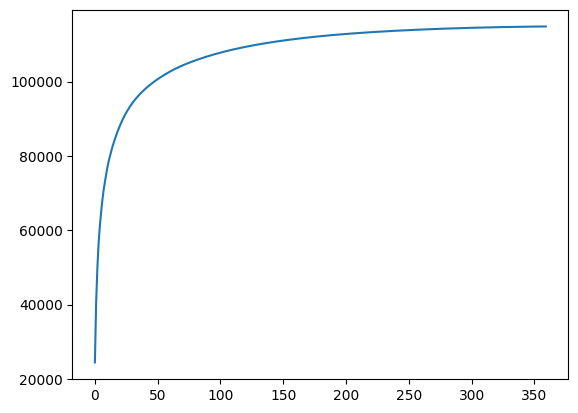

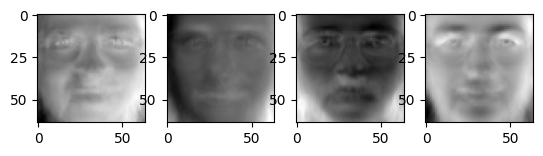

In [114]:
# Now since number of dimensions (D=4096 ) >> number of training samples (N = 360) , we calculate NXN covariance matrix instead of D X D
pca = PCA( optimize = True )
B = pca.fit(X_train)
pca.plot_eigenvals()
num_dim = pca.get_num_components(0.9)
print( num_dim )
B = B[:,:num_dim]
# show top 4 eigenfaces
show_images( B, 4 )


In [115]:
class Projection:
    def __init__( self, B ):
        self.B = B
        
    def reduce_dim( self, X ):
        return  X @ B @ np.linalg.inv(B.T @ B)  

    def reconstruct( self, X_reduced ):
        return X_reduced @ B.T
    
    def get_projection_matrix( self ):
        P = B @ np.linalg.inv(B.T @ B) @ B.T
        return P
    
    def project( self , X ):
        P = self.get_projection_matrix()
        return X @ P

X_train_reduced.shape=(360, 64)


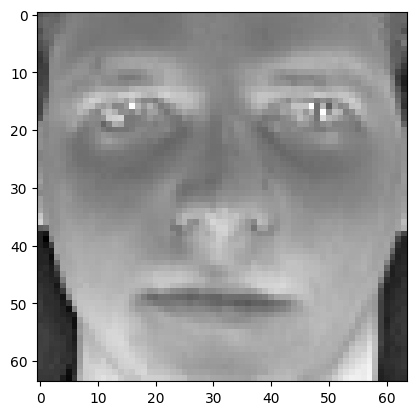

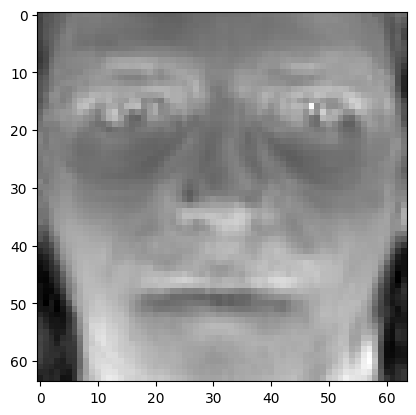

In [116]:
proj = Projection( B )
X_train_reduced = proj.reduce_dim(X_train )
print("X_train_reduced.shape="+str(X_train_reduced.shape) )
show_images(X_train.T, 1)
r_img = proj.reconstruct( X_train_reduced[0,:])
r_img = np.reshape(r_img,(4096,1))
show_images(r_img, 1)

In [117]:
X_test_reduced =proj.reduce_dim(X_test)
print("X_test_reduced.shape="+str(X_test_reduced.shape) )

X_test_reduced.shape=(40, 64)


** Image Recognition **

PCA can be used for face recognition. The idea is to :
1. Reduce dimensions of the face image to be recognized
2. Compare it with the mean image of face class class, where a class here maps to mean of images of a singleperson
3. The class to which the euclidean distance is the smallest is the class to which the person belongs i.e. is the face image of the person belonging to that class

In [118]:
class ImageClassifier:
    def __init__( self, class_count ):
        self.class_count = class_count
        
    def __get_class_mean( self, X, target ):
        class_count = self.class_count
        N,D = X.shape
        mu = np.zeros((class_count,D))
        for i in range(class_count):
            mu[i,:] = (1/N) * np.sum(X[target == i,: ], axis = 0 )
        return mu 

    def __dist(self, v1, v2 ):
        diff = v1-v2
        d = np.sqrt(np.dot(diff,diff))
        return d
                  
    def fit( self,  X, target  ):
        class_count = self.class_count
        mu = self.__get_class_mean( X, target )
        self.mu = mu
        
    def predict( self, test_img ):
        min_dist = float('inf')
        min_class = -1
        for i in range( self.class_count ):
            d = self.__dist(test_img, self.mu[i,:])
            if d < min_dist:
                min_dist = d
                min_class = i
            
        return min_class, self.mu[min_class,:]

In [119]:
from sklearn.metrics import accuracy_score
print("X_test_reduced.shape=" + str(X_test_reduced.shape))
print("X_train_reduced.shape=" + str(X_train_reduced.shape))
img_classifer = ImageClassifier(40)   
img_classifer.fit(X_train_reduced,target_train )
recognized_class, mu_rec = img_classifer.predict( X_test_reduced[5,: ] )
print("recognized_class="+ str(recognized_class))
y_pred, mu_rec = img_classifer.predict( X_test_reduced )

print(f"Accuracy score: {accuracy_score(target_test,y_pred)}")

X_test_reduced.shape=(40, 64)
X_train_reduced.shape=(360, 64)
recognized_class=5


ValueError: shapes (40,64) and (40,64) not aligned: 64 (dim 1) != 40 (dim 0)

** Reconstructing incomplete image **

PCA can also be used to reconstruct an incomplete image. The idea is to project the incomplete image onto the projection matrix of the eigenbasis with K = 64 eigenvectors

In [ ]:
def get_half_image( test_image_index ):
    orig_image = np.copy(X_test[test_image_index,:])
    D, = orig_image.shape
    orig_image = np.reshape(orig_image, (1,D) )
    # blacken lower half of the face
    
    half_image = np.copy(orig_image)
    half_image[0, 2048: 4096] = 0
    return half_image, orig_image

In [ ]:
def reconstruct_half_images( test_indexes ):
    for i in test_indexes:
        half_image, orig_image = get_half_image(i)
        N,D = half_image.shape
        new_image = proj.project( half_image  )
        #target, mu_rec = recognize_image( reduced_half_image[0,: ], X_train_reduced, target_train  )
        #print(target)
        #new_image = reconstruct_image( reduced_half_image, B )
        new_image[0,0:2048,] = orig_image[0, 0:2048]
        images_for_display = np.concatenate((orig_image.T, half_image.T, new_image.T), axis=1 )
        show_images(images_for_display, 3)


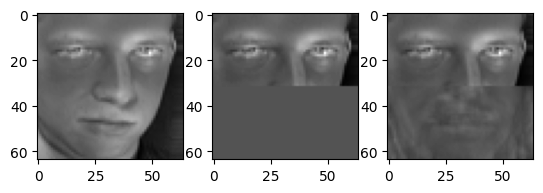

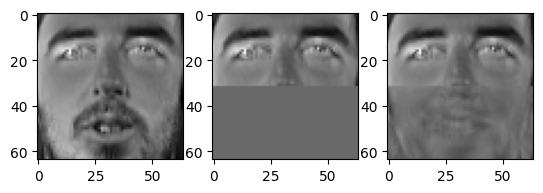

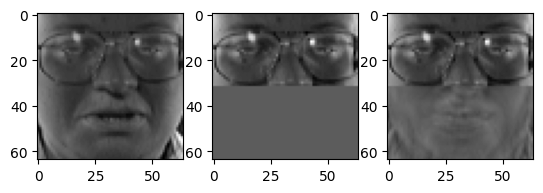

In [ ]:
reconstruct_half_images([0,10,30])

** Other Applications**

This technique can also be used to distingush non-face images form facial images.  If the reconstruction error  (  euclidean distance between  image projected on eigen baseis and original image ) > a defined threshold, the image cannot be a facial image. The threshold needs to be specified  heuristically.
